Árbol de decisión en Python
https://www.aprendemachinelearning.com/arbol-de-decision-en-python-clasificacion-y-prediccion/

In [24]:
# Imports needed for the script
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

**Initial Exploratory Data analysis**

In [25]:
# Loading the dataset
artists_billboard = pd.read_csv(r"artists_billboard_fix3.csv")
# Summarized info for EDA
print("size", artists_billboard.shape)
print("Ten first rows of the dataset")
print(artists_billboard.head())
# How many artists reached #1:
print("Did artists reach #1?")
print("0 -> not reached #1")
print("1 -> reached #1")
print(artists_billboard.groupby('top').size())

size (635, 11)
Ten first rows of the dataset
   id                 title  \
0   0  Small Town Throwdown   
1   1             Bang Bang   
2   2                Timber   
3   3       Sweater Weather   
4   4             Automatic   

                                              artist        mood  \
0  BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...    Brooding   
1              JESSIE J, ARIANA GRANDE & NICKI MINAJ  Energizing   
2                            PITBULL featuring KE$HA     Excited   
3                                  THE NEIGHBOURHOOD    Brooding   
4                                    MIRANDA LAMBERT    Yearning   

          tempo               genre artist_type  chart_date  durationSeg  top  \
0  Medium Tempo         Traditional        Male    20140628        191.0    0   
1  Medium Tempo                 Pop      Female    20140816        368.0    0   
2  Medium Tempo               Urban       Mixed    20140118        223.0    1   
3  Medium Tempo  Alternative & Punk

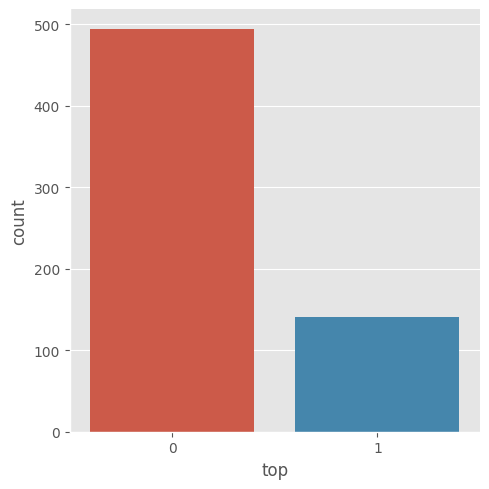

In [26]:
#Visualization of top #1 according to group
#The tutorial I folowed used sb.factorplot, but this attribute has been deprecated from newer versions
sb.catplot(x='top', data=artists_billboard, kind='count')

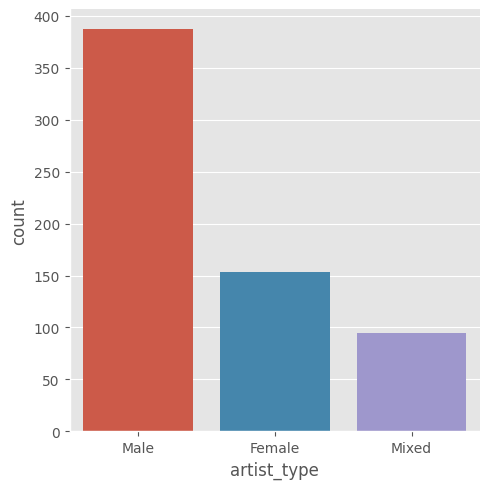

In [27]:
# Grouping by artists gender
# Again, the author's used factorplot, which is obsolete
# sb.factorplot('artist_type',data=artists_billboard,kind="count")
sb.catplot(x='artist_type', data=artists_billboard, kind='count')


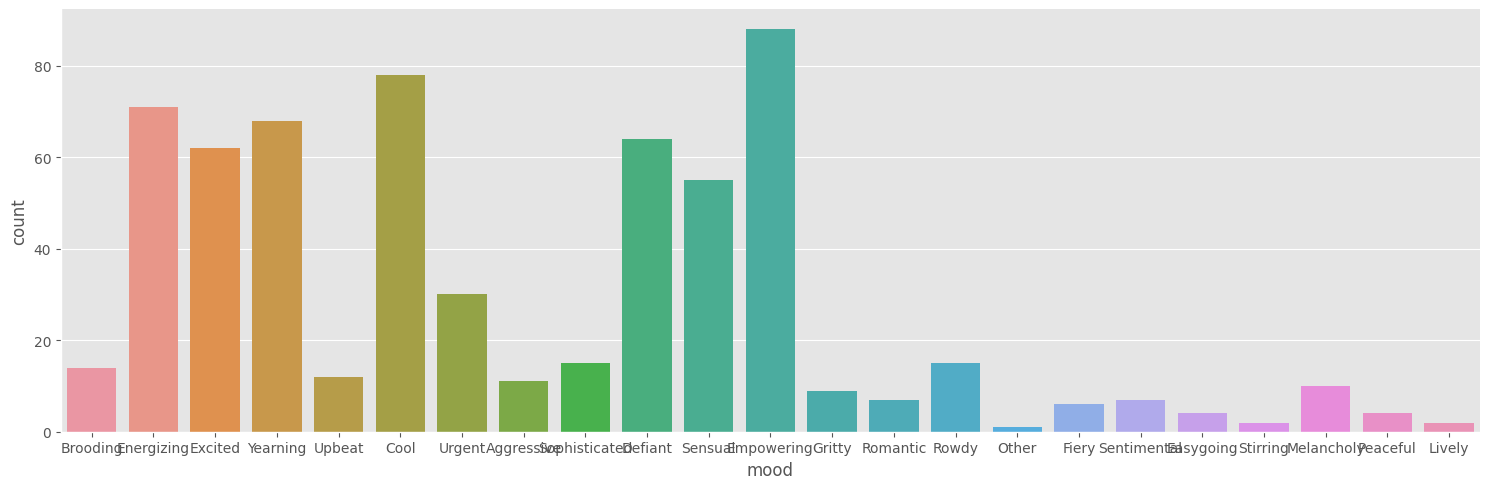

In [28]:
# Data set grouped by mood
sb.catplot(x='mood', data=artists_billboard, kind='count', aspect=3)
plt.show()

The highest rates were achieved by 7 different moods:
Energizing, excited, yearning, cool, defiant, sensual, empowering

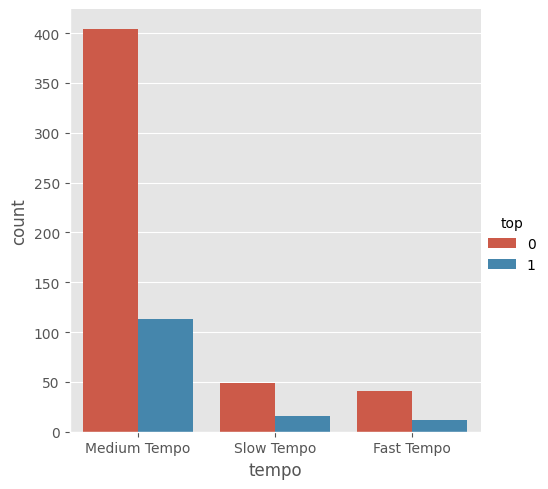

In [29]:
# Dataset grouped by tempo and whether they reached #1 or not
sb.catplot(x='tempo', data=artists_billboard, hue='top', kind='count')

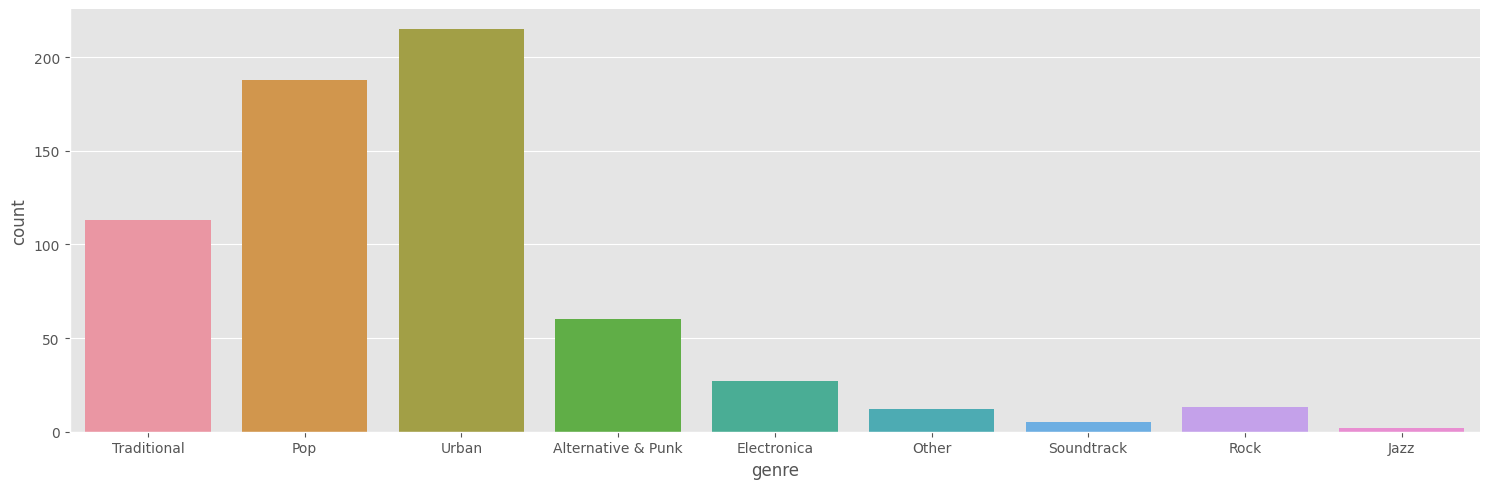

In [30]:
# Dataset grouped by music genre
sb.catplot(x='genre', data=artists_billboard, kind='count', aspect=3)

The most frequent genre were traditional, pop and urban music

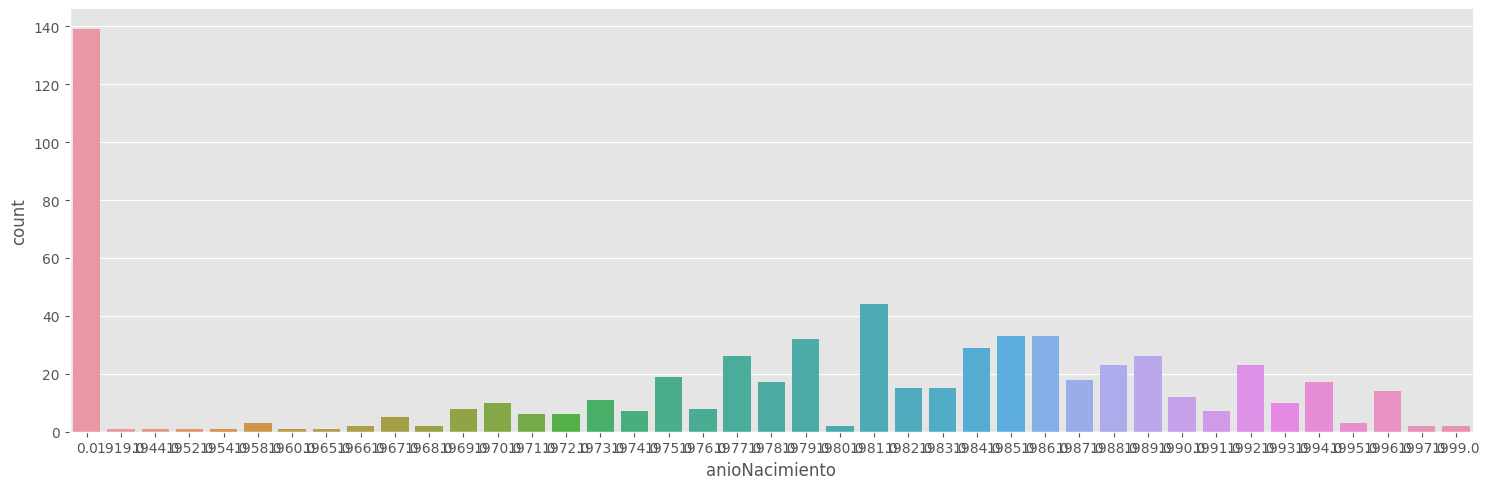

In [31]:
# Date birth of the artists
sb.catplot(x='anioNacimiento', data=artists_billboard, kind='count', aspect=3)

The high number of artists born in year "0" is due to lack of information

As there are very little artists who reach #1 (unbalanced data), the author also introduced in the dataset other artists from 2004 to 2013

**Data balance**

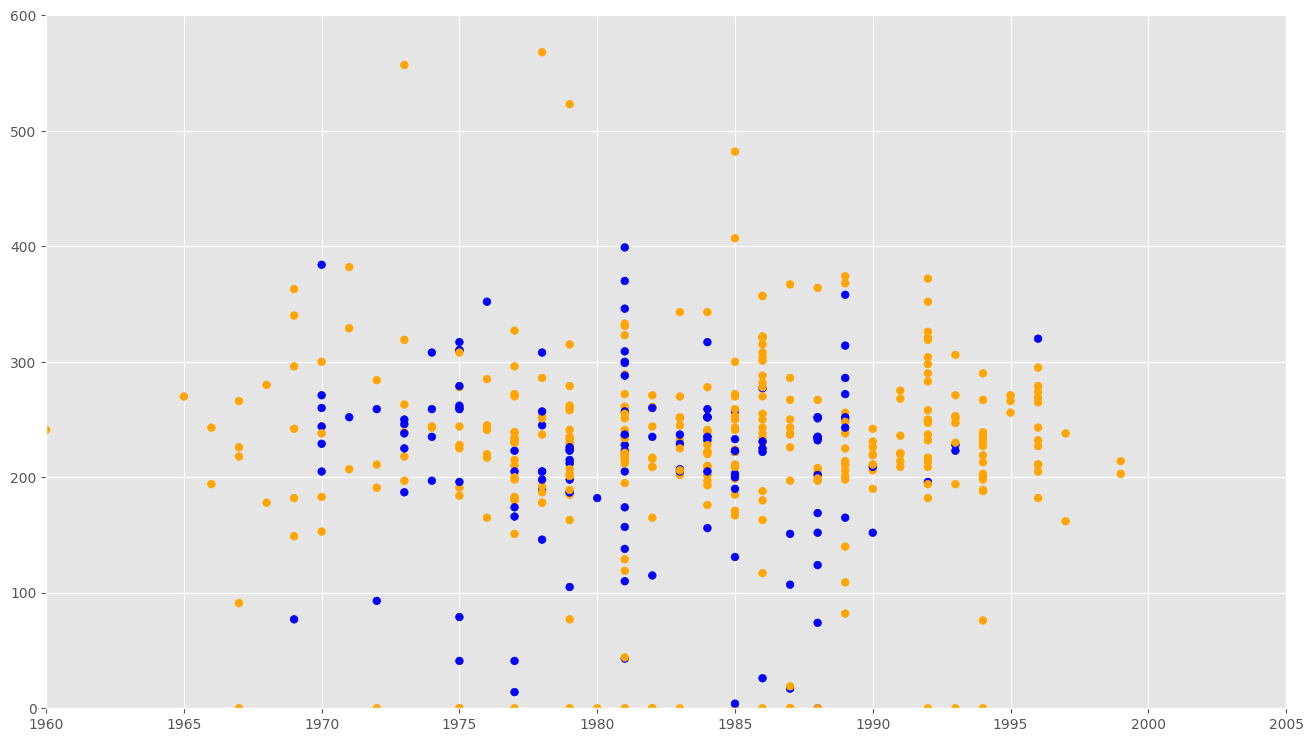

In [32]:
# IMPORTANTE: ESTA CELDA Y LA SIGUIENTE HAY QUE COMPARARLAS CON EL REPOSITORIO DE GITHUB, PORQUE HAY UN PASO QUE NO HA DESCRITO
# Y DA UN ERROR LUEGO https://github.com/jbagnato/machine-learning/blob/master/Ejercicio_Arbol_de_Decision.ipynb

colores=['orange','blue']
tamanios=[60,40]

f1 = artists_billboard['anioNacimiento'].values
f2 = artists_billboard['durationSeg'].values

asignar=[]
for index, row in artists_billboard.iterrows():
    asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([1960,2005,0,600])
plt.show()

This chart represents a scatter plot considering the year of birth of artists. No top songs were drawn in orange while top songs were plotted in blue. It seems there is no correlation between these two variables.

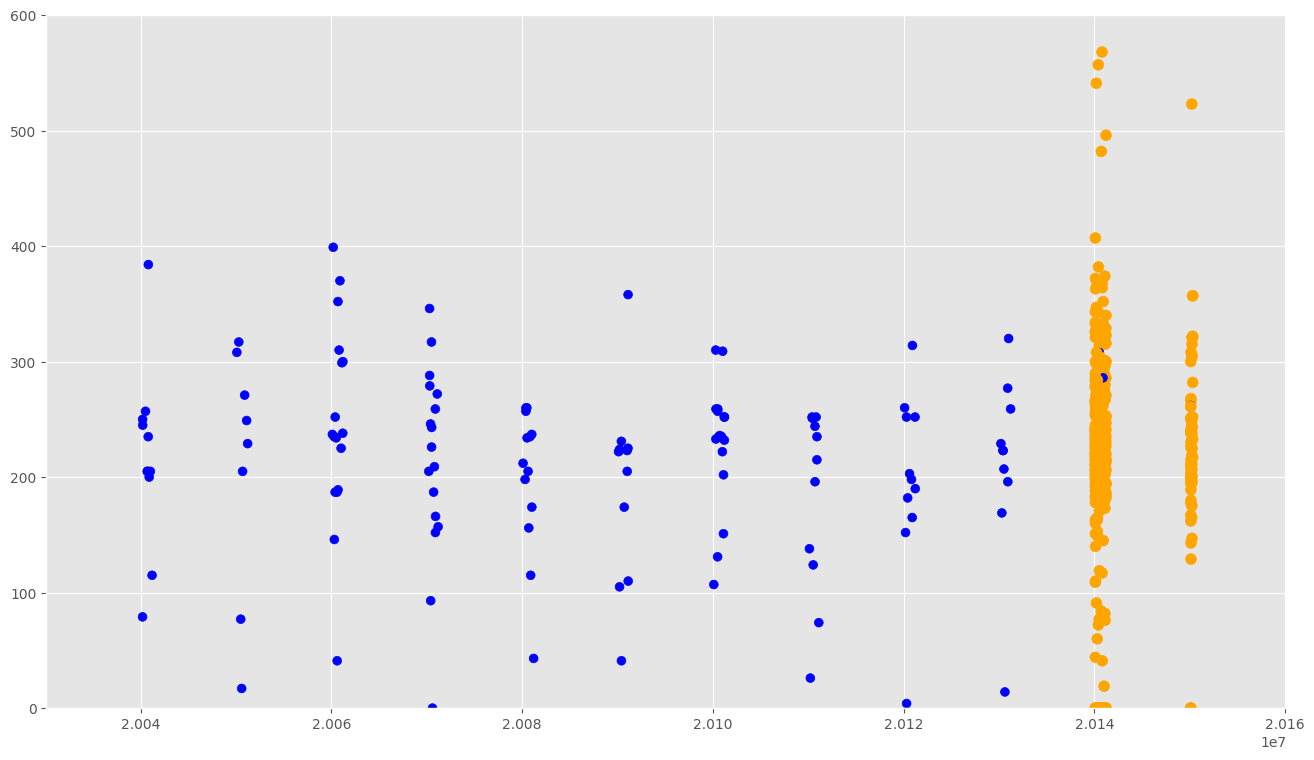

In [33]:
f1 = artists_billboard['chart_date'].values
f2 = artists_billboard['durationSeg'].values

asignar=[]
asignar2=[]
for index, row in artists_billboard.iterrows():
    asignar.append(colores[row['top']])
    asignar2.append(tamanios[row['top']])
# I have followed the tutorial, but both at the website and the author's repository, appeared the following line
# plt.scatter(f1, f2, c=asignar, s=tamanios)
# However, this line showed an error when the executing the cell as parameter s requires an integer, float or array
# which determines whether all the data have the same size of they have a specified size according to the s array
plt.scatter(f1, f2, c=asignar, s=asignar2)
plt.axis([20030101,20160101,0,600])
plt.show()

This scatter plot shows more top songs on the left side as the author took top songs from previous years to balance the data from the billboard

**Dealing with the data: Year of birth 0**

We seek for the feature "Age of the artist when appeared on billboard".
We are filling the "year 0" values with None

In [34]:
def edad_fix(anio):
    if anio==0:
        return None
    return anio

artists_billboard['anioNacimiento']=artists_billboard.apply(lambda x: edad_fix(x['anioNacimiento']), axis=1);

We are estimating this age in a new column called “edad_en_billboard”, subtracting the first four characters in chart_date to year of birth using a lambda function. Cells with None remain with none

In [35]:
def calcula_edad(anio,cuando):
    cad = str(cuando)
    momento = cad[:4]
    if anio==0.0:
        return None
    return int(momento) - anio

artists_billboard['edad_en_billboard']=artists_billboard.apply(lambda x: calcula_edad(x['anioNacimiento'],x['chart_date']), axis=1);

We will fill the remaining gaps with random ages, considering the average and standard deviation of ages from the dataset. This results in random ages from 21 to 38. Despite this information could be available in other websites, the author wanted to show a different method for obtaining this information

In [36]:
age_avg = artists_billboard['edad_en_billboard'].mean() # Average
age_std = artists_billboard['edad_en_billboard'].std() # Standard deviation
age_null_count = artists_billboard['edad_en_billboard'].isnull().sum() # Count None values
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count) # Generate random ages

conValoresNulos = np.isnan(artists_billboard['edad_en_billboard'])

artists_billboard.loc[np.isnan(artists_billboard['edad_en_billboard']), 'edad_en_billboard'] = age_null_random_list
artists_billboard['edad_en_billboard'] = artists_billboard['edad_en_billboard'].astype(int)
print("Edad Promedio: " + str(age_avg))
print("Desvió Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))

Edad Promedio: 30.10282258064516
Desvió Std Edad: 8.40078832861513
Intervalo para asignar edad aleatoria: 21 a 38


The new values are shown in green in this plot

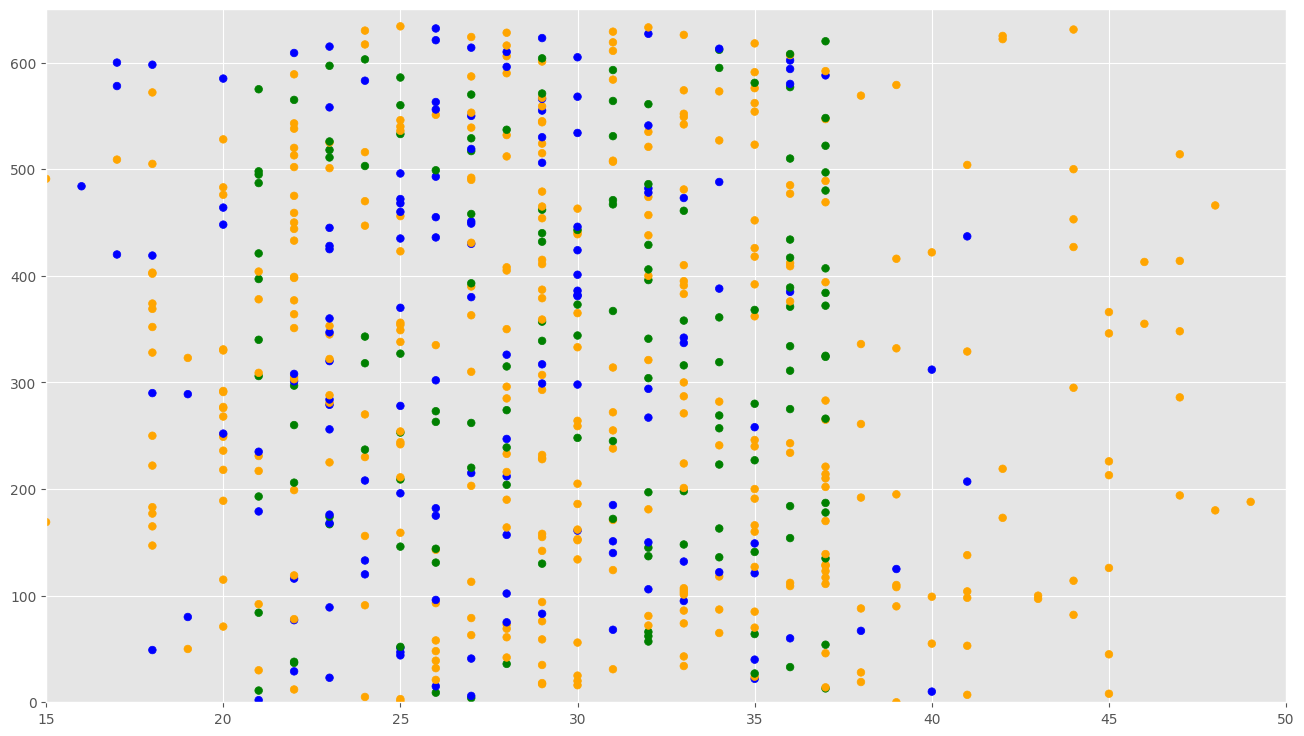

In [37]:
f1 = artists_billboard['edad_en_billboard'].values
f2 = artists_billboard.index

colores = ['orange','blue','green']

asignar=[]
for index, row in artists_billboard.iterrows():
    if (conValoresNulos[index]):
        asignar.append(colores[2]) # verde
    else:
        asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([15,50,0,650])
plt.show()

**DATA MAPPING**

Transform some input data into categorical values: As an example, ages can be grouped from 16 to 21; the songs were grouped according to their duration, and mood could be also grouped.

In [38]:
# Mood Mapping
artists_billboard['moodEncoded'] = artists_billboard['mood'].map( {'Energizing': 6,
                                        'Empowering': 6,
                                        'Cool': 5,
                                        'Yearning': 4, # anhelo, deseo, ansia
                                        'Excited': 5, #emocionado
                                        'Defiant': 3,
                                        'Sensual': 2,
                                        'Gritty': 3, #coraje
                                        'Sophisticated': 4,
                                        'Aggressive': 4, # provocativo
                                        'Fiery': 4, #caracter fuerte
                                        'Urgent': 3,
                                        'Rowdy': 4, #ruidoso alboroto
                                        'Sentimental': 4,
                                        'Easygoing': 1, # sencillo
                                        'Melancholy': 4,
                                        'Romantic': 2,
                                        'Peaceful': 1,
                                        'Brooding': 4, # melancolico
                                        'Upbeat': 5, #optimista alegre
                                        'Stirring': 5, #emocionante
                                        'Lively': 5, #animado
                                        'Other': 0,'':0} ).astype(int)
# Tempo Mapping
artists_billboard['tempoEncoded'] = artists_billboard['tempo'].map( {'Fast Tempo': 0, 'Medium Tempo': 2, 'Slow Tempo': 1, '': 0} ).astype(int)
# Genre Mapping
artists_billboard['genreEncoded'] = artists_billboard['genre'].map( {'Urban': 4,
                                          'Pop': 3,
                                          'Traditional': 2,
                                          'Alternative & Punk': 1,
                                         'Electronica': 1,
                                          'Rock': 1,
                                          'Soundtrack': 0,
                                          'Jazz': 0,
                                          'Other':0,'':0}
                                       ).astype(int)
# artist_type Mapping
artists_billboard['artist_typeEncoded'] = artists_billboard['artist_type'].map( {'Female': 2, 'Male': 3, 'Mixed': 1, '': 0} ).astype(int)


# Mapping edad en la que llegaron al billboard
artists_billboard.loc[ artists_billboard['edad_en_billboard'] <= 21, 'edadEncoded']                         = 0
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 21) & (artists_billboard['edad_en_billboard'] <= 26), 'edadEncoded'] = 1
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 26) & (artists_billboard['edad_en_billboard'] <= 30), 'edadEncoded'] = 2
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 30) & (artists_billboard['edad_en_billboard'] <= 40), 'edadEncoded'] = 3
artists_billboard.loc[ artists_billboard['edad_en_billboard'] > 40, 'edadEncoded'] = 4

# Mapping Song Duration
artists_billboard.loc[ artists_billboard['durationSeg'] <= 150, 'durationEncoded']                          = 0
artists_billboard.loc[(artists_billboard['durationSeg'] > 150) & (artists_billboard['durationSeg'] <= 180), 'durationEncoded'] = 1
artists_billboard.loc[(artists_billboard['durationSeg'] > 180) & (artists_billboard['durationSeg'] <= 210), 'durationEncoded'] = 2
artists_billboard.loc[(artists_billboard['durationSeg'] > 210) & (artists_billboard['durationSeg'] <= 240), 'durationEncoded'] = 3
artists_billboard.loc[(artists_billboard['durationSeg'] > 240) & (artists_billboard['durationSeg'] <= 270), 'durationEncoded'] = 4
artists_billboard.loc[(artists_billboard['durationSeg'] > 270) & (artists_billboard['durationSeg'] <= 300), 'durationEncoded'] = 5
artists_billboard.loc[ artists_billboard['durationSeg'] > 300, 'durationEncoded'] = 6

Now we have a new dataset called artists_encoded including the features which will generate the decision tree. We remove the columns we will not use using drop

In [39]:
drop_elements = ['id','title','artist','mood','tempo','genre','artist_type','chart_date','anioNacimiento','durationSeg','edad_en_billboard']
artists_encoded = artists_billboard.drop(drop_elements, axis = 1)

**DATA DISTRIBUTION ACCORDING TO ENCODED DATA**


The new grouped data will show how the top 1 are distributed according these new features. The column sum shows these top, as only contribute data whith value 1.

In [40]:
artists_encoded[['moodEncoded', 'top']].groupby(['moodEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
moodEncoded                    
0            0.000000     1   0
1            0.000000     8   0
2            0.274194    62  17
3            0.145631   103  15
4            0.136986   146  20
5            0.294872   156  46
6            0.270440   159  43

The most of top1 correspond to congs with moods 5 and 6

In [41]:
artists_encoded[['artist_typeEncoded', 'top']].groupby(['artist_typeEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                        mean count sum
artist_typeEncoded                    
1                   0.305263    95  29
2                   0.320261   153  49
3                   0.162791   387  63

Male gender (3) reached a higher number of top1

In [42]:
artists_encoded[['genreEncoded', 'top']].groupby(['genreEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                  mean count sum
genreEncoded                    
0             0.105263    19   2
1             0.070000   100   7
2             0.008850   113   1
3             0.319149   188  60
4             0.330233   215  71

Urban and Pop genders were the most popular

In [43]:
artists_encoded[['tempoEncoded', 'top']].groupby(['tempoEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top           
                  mean count  sum
tempoEncoded                     
0             0.226415    53   12
1             0.246154    65   16
2             0.218569   517  113

Medium tempo achieved the highest number of top1

In [44]:
artists_encoded[['durationEncoded', 'top']].groupby(['durationEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                     mean count sum
durationEncoded                    
0.0              0.295775    71  21
1.0              0.333333    30  10
2.0              0.212963   108  23
3.0              0.202381   168  34
4.0              0.232143   112  26
5.0              0.145455    55   8
6.0              0.208791    91  19

The duration of the songs

In [45]:
artists_encoded[['edadEncoded', 'top']].groupby(['edadEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
edadEncoded                    
0.0          0.239437    71  17
1.0          0.331034   145  48
2.0          0.260563   142  37
3.0          0.160870   230  37
4.0          0.042553    47   2

The most top1 had an average age between 21 and 25 years old (group 1)